In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier

from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

from sklearn import datasets
from matplotlib.colors import ListedColormap

class_name = 'Occupancy'
df_training = pd.read_csv('training.csv', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)

df_test = pd.read_csv('test.csv', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)

columns2remove = ['date', 'Unnamed: 0', 'cumulative_hour', 'cumulative_minute', 'day']
df_training.drop(columns2remove, inplace=True, axis=1)
df_test.drop(columns2remove, inplace=True, axis=1)

df_training.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,hour,minute,day_minute,weekend
0,23.7000,26.272,585.200000,749.200000,0.004764,1,14,19,859,0
1,23.7180,26.290,578.400000,760.400000,0.004773,1,14,20,860,0
2,23.7300,26.230,572.666667,769.666667,0.004765,1,14,21,861,0
3,23.7225,26.125,493.750000,774.750000,0.004744,1,14,22,862,0
4,23.7540,26.200,488.600000,779.000000,0.004767,1,14,23,863,0


------

Normalization

In [2]:
from sklearn.preprocessing import StandardScaler

attributes = [col for col in df_training.columns if col != class_name]

#Primo tipo di normalizzazione: Z-Score 
scaler = StandardScaler()
X_train = scaler.fit_transform(df_training[attributes].values)
y_train = df_training[class_name]

X_test = scaler.fit_transform(df_test[attributes].values)
y_test = df_test[class_name]

-------

Obeserbing F1-score and Accuracy performance by varing the number of neighbors

In [5]:
#Best number of k
#d e' il dizionario {k: f1-score}
accuracy = []
f1score = []

for k in range(1, 51):
    clf = KNeighborsClassifier(n_neighbors=k, weights='uniform') #una volta fatto gridsearchCV, usiamo il parametro migliore per weights
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    #print('k = {}'.format(k))
    #print('Accuracy %s' % accuracy_score(y_test, y_pred))
    #print('F1-score %s' % f1_score(y_test, y_pred, average=None))
    #print(classification_report(y_test, y_pred))
    
    f1score.append(classification_report(y_test, y_pred, output_dict = True)['1']['f1-score'])
    accuracy.append(accuracy_score(y_test, y_pred))
    
    #print('---------------------------------------')
    
#print(d)

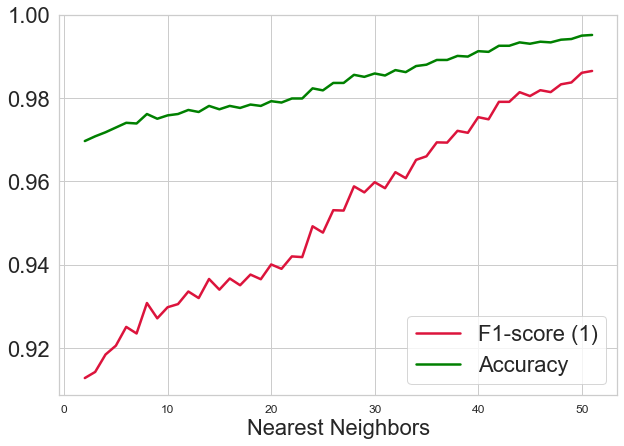

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

f=22
plt.figure(figsize = (10,7))
sns.set(style='whitegrid')
sns.lineplot(x=range(2, len(f1score)+2), y=f1score, color = 'crimson', lw=2.5)
sns.lineplot(x=range(2, len(f1score)+2), y=accuracy, color = 'green', lw=2.5)
plt.xlabel('Nearest Neighbors', fontsize=f)
plt.legend(['F1-score (1)', 'Accuracy'], fontsize=f, loc='lower right')
plt.xticks(fontsize=12)
plt.yticks([0.92, 0.94, 0.96, 0.98, 1], fontsize=f)

plt.show()

-------

Looking for the best combination of features, using cross validation and grid search for each combination

In [6]:
%%time
#creazione di tutte le combinazioni di attributi da testare con grid search e cross validation

from itertools import combinations
import operator #per trovare il numero cv migliore nel dizionario delle performance

tested_attributes = ['Temperature', 'Light', 'CO2', 'Humidity', 'HumidityRatio'] # elementi "fissi" che ci saranno ad ogni classificazione

summary = []
i=1

scaler = StandardScaler()
y_train = df_training[class_name]
y_test = df_test[class_name]

for r in range(2, 6):
    for attr in combinations(tested_attributes, r):
        # 'attr' è la combinazione di attributi da testare per ogni iterazione
        print("Attributes to test in iteration {}: {}".format(i, attr))
        X_train = scaler.fit_transform(df_training[list(attr)].values)
        X_test = scaler.fit_transform(df_test[list(attr)].values)
        
        #grid search per attr
        parameters = {'n_neighbors': np.arange(1, 51), 'weights':['uniform', 'distance']}

        knn = KNeighborsClassifier()
        search = GridSearchCV(knn, parameters, n_jobs = -1)
        search.fit(X_train, y_train)

        clf = search.best_estimator_
        print("Best parameter for this attributes:", clf)

        #Cross validation per trovare il numero migliore di cv      
        cv_performances_f1 = {}
        cv_performances_acc = {}
        for k in range(3, 50):
            scores_acc = cross_val_score(clf, X_train, y_train, cv=k, n_jobs = -1)
            scores_f1 = cross_val_score(clf, X_train, y_train, cv=k, scoring='f1_macro', n_jobs = -1)
            cv_performances_f1[k] = scores_f1.mean()
            cv_performances_acc[k] = scores_acc.mean()
            
        best_performances_f1 = max(cv_performances_f1.items(), key=operator.itemgetter(1))[0]
        print("Best performance with cv = {}, f1-score = {}".format(best_performances_f1, cv_performances_f1[best_performances_f1]))
        print("Best performance with cv = {}, accuracy = {}".format(best_performances_f1, cv_performances_acc[best_performances_f1]))
        
        #classification on test set using best classifier for this iteration
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        print()
        print('Accuracy %s' % accuracy_score(y_test, y_pred))
        print('F1-score %s' % f1_score(y_test, y_pred, average=None))
        print(classification_report(y_test, y_pred))
        report = classification_report(y_test, y_pred, output_dict=True)
        
        summary.append({'iteration' : i,
                    'attributes': attr,
                    'classificator': clf,
                    'cv': best_performances_f1,
                    'cv_accuracy' : cv_performances_acc[best_performances_f1],
                    'cv_f1': cv_performances_f1[best_performances_f1],
                    'test_accuracy' : accuracy_score(y_test, y_pred),
                    'f1-score [0]' : f1_score(y_test, y_pred, average=None)[0],
                    'f1-score [1]' : f1_score(y_test, y_pred, average=None)[1],
                    'precision [1]' : report['1']['precision'],
                    'recall [1]' : report['1']['recall']})
        print("---------------------------------------------------------\n\n\n")
        
        i+=1

Attributes to test in iteration 1: ('Temperature', 'Light')
Best parameter for this attributes: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=47, p=2,
                     weights='uniform')
Best performance with cv = 31, f1-score = 0.9785604996430807
Best performance with cv = 31, accuracy = 0.9823595811355508

Accuracy 0.9845979247730221
F1-score [0.99054632 0.95846087]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5071
           1       0.92      1.00      0.96      1097

    accuracy                           0.98      6168
   macro avg       0.96      0.99      0.97      6168
weighted avg       0.99      0.98      0.98      6168

---------------------------------------------------------



Attributes to test in iteration 2: ('Temperature', 'CO2')
Best parameter for this attributes: KNeighborsClassifier(algorithm='auto', leaf_size=3

Best parameter for this attributes: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=31, p=2,
                     weights='uniform')
Best performance with cv = 43, f1-score = 0.9766760492100868
Best performance with cv = 43, accuracy = 0.9811791896941972

Accuracy 0.9891374837872893
F1-score [0.9933512  0.97034086]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5071
           1       0.94      1.00      0.97      1097

    accuracy                           0.99      6168
   macro avg       0.97      0.99      0.98      6168
weighted avg       0.99      0.99      0.99      6168

---------------------------------------------------------



Attributes to test in iteration 12: ('Temperature', 'Light', 'Humidity')
Best parameter for this attributes: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     m

Best parameter for this attributes: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=46, p=2,
                     weights='uniform')
Best performance with cv = 43, f1-score = 0.9738239045138111
Best performance with cv = 43, accuracy = 0.9793050483552158

Accuracy 0.9858949416342413
F1-score [0.99136133 0.9615894 ]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5071
           1       0.93      0.99      0.96      1097

    accuracy                           0.99      6168
   macro avg       0.97      0.99      0.98      6168
weighted avg       0.99      0.99      0.99      6168

---------------------------------------------------------



Attributes to test in iteration 22: ('Temperature', 'Light', 'CO2', 'HumidityRatio')
Best parameter for this attributes: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
          

In [7]:
#ordiniamo per precision per trovare il modello migliore secondo questo parametro
precisions = []

for i in range(len(summary)):
    precisions.append(float(summary[i]['precision [1]']))

#precision e summary hanno gli stessi indici
    
best_idx = precisions.index(max(precisions)) #index of the best classificator according to precision
summary[best_idx] #best classificator description

{'iteration': 11,
 'attributes': ('Temperature', 'Light', 'CO2'),
 'classificator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=31, p=2,
                      weights='uniform'),
 'cv': 43,
 'cv_accuracy': 0.9811791896941972,
 'cv_f1': 0.9766760492100868,
 'test_accuracy': 0.9891374837872893,
 'f1-score [0]': 0.9933511957923984,
 'f1-score [1]': 0.970340858787074,
 'precision [1]': 0.9432013769363167,
 'recall [1]': 0.9990884229717412}

In [8]:
# Analizziamo le performance del modello migliore
X_train = scaler.fit_transform(df_training[['Temperature', 'Light', 'CO2']].values)
X_test = scaler.fit_transform(df_test[['Temperature', 'Light', 'CO2']].values)

clf = KNeighborsClassifier(n_neighbors=31, weights = 'uniform')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
        
print()
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, output_dict=True)


Accuracy 0.9891374837872893
F1-score [0.9933512  0.97034086]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5071
           1       0.94      1.00      0.97      1097

    accuracy                           0.99      6168
   macro avg       0.97      0.99      0.98      6168
weighted avg       0.99      0.99      0.99      6168



In [9]:
%%time
#Cross validation per trovare il numero migliore di cv


import operator #per trovare il numero cv migliore nel dizionario delle performance

cv_performances = {}
for k in range(3, 20):
    print('k = ', k)
    scores = cross_val_score(clf, X_train, y_train, cv=k, n_jobs = -1)
    #print('NOR: Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))
    
    scores = cross_val_score(clf, X_train, y_train, cv=k, scoring='f1_macro', n_jobs = -1)
    #print('NOR: F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))
    
    
    
    scores_inv = cross_val_score(clf, X_train, y_train_inv, cv=k, n_jobs = -1)
    #print('INV: Accuracy: %0.4f (+/- %0.3f)' % (scores_inv.mean(), scores_inv.std()))
    
    scores_inv = cross_val_score(clf, X_train, y_train_inv, cv=k, scoring='f1_macro', n_jobs = -1)
    #print('INV: F1-score: %0.4f (+/- %0.3f)' % (scores_inv.mean(), scores_inv.std()))
    
    cv_performances[k] = scores_inv.mean()
    #print('---------------------------------')

#I VALORI CAMBIANO


best_performance = max(cv_performances.items(), key=operator.itemgetter(1))[0]
print("Best performance with k = {}, f1-score = {}".format(best_performance, cv_performances[best_performance]))

k =  3


NameError: name 'y_train_inv' is not defined

Testiamo le variabili create da noi, per vedere se il modello ha una performance migliore rispetto al migliore trovato.
Togliamo luce per penalizzarlo ulteriormente, dato che era la variabile più importante per classificare bene

In [7]:
attr2 = [a for a in attributes if a != "Light"]
# 'attr' è la combinazione di attributi da testare per ogni iterazione
print("Attribute to test in iteration {}: {}".format(i+1, attr2))
X_train = scaler.fit_transform(df_training[attr2].values)
X_test = scaler.fit_transform(df_test[attr2].values)
        
#grid search per attr
parameters = {'n_neighbors': np.arange(1, 50 + 1), 'weights':['uniform', 'distance']}

knn = KNeighborsClassifier()
search = GridSearchCV(knn, parameters, n_jobs = -1)
search.fit(X_train, y_train)

clf = search.best_estimator_
print("Best parameter for this attributes:", clf)

#Cross validation per trovare il numero migliore di cv      
cv_performances_f1 = {}
cv_performances_acc = {}
for k in range(3, 50):
    scores_acc = cross_val_score(clf, X_train, y_train, cv=k, n_jobs = -1)
    scores_f1 = cross_val_score(clf, X_train, y_train, cv=k, scoring='f1_macro', n_jobs = -1)
    cv_performances_f1[k] = scores_f1.mean()
    cv_performances_acc[k] = scores_acc.mean()
            
best_performances_f1 = max(cv_performances_f1.items(), key=operator.itemgetter(1))[0]
best_performances_acc = max(cv_performances_acc.items(), key=operator.itemgetter(1))[0]
print("Best performance with cv = {}, f1-score = {}".format(best_performances_f1, cv_performances_f1[best_performances_f1]))
print("Best performance with cv = {}, accuracy = {}".format(best_performances_acc, cv_performances_acc[best_performances_acc]))

#classification on test set using best classifier for this iteration
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
        
print()
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, output_dict=True)

NameError: name 'i' is not defined

In [11]:
#Test attributi creati da noi
attr2 = ['hour', 'minute', 'day_minute', 'weekend']
# 'attr' è la combinazione di attributi da testare per ogni iterazione
print("Attribute to test in iteration {}: {}".format(i+1, attr2))
X_train = scaler.fit_transform(df_training[attr2].values)
X_test = scaler.fit_transform(df_test[attr2].values)
        
#grid search per attr
parameters = {'n_neighbors': np.arange(1, 50 + 1), 'weights':['uniform', 'distance']}

knn = KNeighborsClassifier()
search = GridSearchCV(knn, parameters, n_jobs = -1)
search.fit(X_train, y_train)

clf = search.best_estimator_
print("Best parameter for this attributes:", clf)

#Cross validation per trovare il numero migliore di cv      
cv_performances_f1 = {}
cv_performances_acc = {}
for k in range(3, 50):
    scores_acc = cross_val_score(clf, X_train, y_train, cv=k, n_jobs = -1)
    scores_f1 = cross_val_score(clf, X_train, y_train, cv=k, scoring='f1_macro', n_jobs = -1)
    cv_performances_f1[k] = scores_f1.mean()
    cv_performances_acc[k] = scores_acc.mean()
            
best_performances_f1 = max(cv_performances_f1.items(), key=operator.itemgetter(1))[0]
best_performances_acc = max(cv_performances_acc.items(), key=operator.itemgetter(1))[0]
print("Best performance with cv = {}, f1-score = {}".format(best_performances_f1, cv_performances_f1[best_performances_f1]))
print("Best performance with cv = {}, accuracy = {}".format(best_performances_acc, cv_performances_acc[best_performances_acc]))

#classification on test set using best classifier for this iteration
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
        
print()
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, output_dict=True)

Attribute to test in iteration 26: ['hour', 'minute', 'day_minute', 'weekend']
Best parameter for this attributes: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='distance')
Best performance with cv = 16, f1-score = 0.9210849091062305
Best performance with cv = 8, accuracy = 0.9352418010005559

Accuracy 0.9534695201037614
F1-score [0.97202456 0.86181993]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5071
           1       0.91      0.82      0.86      1097

    accuracy                           0.95      6168
   macro avg       0.94      0.90      0.92      6168
weighted avg       0.95      0.95      0.95      6168



In [12]:
#Combinazioni degli attributi ordinate per precision[1]
from collections import OrderedDict
precisions = []

for i in range(len(summary)):
    precisions.append(float(summary[i]['precision [1]']))
d = {}
i = 0
for r in range(2, 6):
    for attr in combinations(tested_attributes, r):
        d[attr] = precisions[i]
        i += 1

sortedDict = OrderedDict(sorted(d.items(), key=lambda x: x[1]))
print('Attributes          :       precision[1]\n')    
for key in sortedDict:
    print(key, ':', sortedDict[key])


Attributes          :       precision[1]

('CO2', 'HumidityRatio') : 0.2503311258278146
('CO2', 'Humidity', 'HumidityRatio') : 0.297910447761194
('CO2', 'Humidity') : 0.30039750141964794
('Temperature', 'CO2', 'HumidityRatio') : 0.3658878504672897
('Temperature', 'CO2', 'Humidity', 'HumidityRatio') : 0.3818737270875764
('Temperature', 'CO2', 'Humidity') : 0.3969046430354468
('Temperature', 'CO2') : 0.42652084757347913
('Humidity', 'HumidityRatio') : 0.5810276679841897
('Temperature', 'Humidity') : 0.6403743315508021
('Temperature', 'Humidity', 'HumidityRatio') : 0.6615074024226111
('Temperature', 'HumidityRatio') : 0.6767819336626676
('Light', 'CO2', 'Humidity', 'HumidityRatio') : 0.8468677494199536
('Light', 'CO2', 'Humidity') : 0.8476411446249034
('Light', 'CO2', 'HumidityRatio') : 0.8753993610223643
('Light', 'HumidityRatio') : 0.8824476650563607
('Light', 'Humidity', 'HumidityRatio') : 0.8860145513338723
('Temperature', 'Light', 'Humidity', 'HumidityRatio') : 0.8896103896103896
('T

In [13]:
#Combinazioni degli attributi ordinate per recall[1]
recalls = []

for i in range(len(summary)):
    recalls.append(float(summary[i]['recall [1]']))
d2 = {}
i = 0
for r in range(2, 6):
    for attr in combinations(tested_attributes, r):
        d2[attr] = recalls[i]
        i += 1

sortedDict = OrderedDict(sorted(d2.items(), key=lambda x: x[1]))
print('Attributes          :       recall[1]\n')          
for key in sortedDict:
    print(key, ':', sortedDict[key])


Attributes          :       recall[1]

('CO2', 'HumidityRatio') : 0.3445761166818596
('CO2', 'Humidity', 'HumidityRatio') : 0.45487693710118504
('CO2', 'Humidity') : 0.4822242479489517
('Temperature', 'CO2') : 0.568824065633546
('Temperature', 'CO2', 'Humidity', 'HumidityRatio') : 0.6836827711941659
('Temperature', 'CO2', 'HumidityRatio') : 0.7137648131267093
('Temperature', 'CO2', 'Humidity') : 0.7247037374658158
('Humidity', 'HumidityRatio') : 0.8040109389243391
('Temperature', 'Humidity') : 0.8732907930720146
('Temperature', 'HumidityRatio') : 0.8742023701002735
('Temperature', 'Humidity', 'HumidityRatio') : 0.8960802187784868
('Temperature', 'Light', 'CO2', 'HumidityRatio') : 0.9799453053783045
('Temperature', 'Light', 'CO2', 'Humidity', 'HumidityRatio') : 0.9881494986326345
('Temperature', 'Light', 'CO2', 'Humidity') : 0.9927073837739289
('Light', 'CO2', 'Humidity', 'HumidityRatio') : 0.9981768459434822
('Temperature', 'Light') : 0.9990884229717412
('Light', 'CO2') : 0.99908842297